<font size="2"> To install new library (since everything is running on kernel python3.10): 
/$ python3.10 -m pip install *pandas*
</font>

In [1]:
# import all files from necessary directory
from os import listdir
import os
from os.path import isfile, join
dir = "/data/Riabova/train3"
all_files = [join(dir, f) for f in listdir(dir)]
all_files_mhd = [string for string in all_files if string.endswith("mhd")]
len(all_files_mhd)

288

In [2]:
import numpy as np

''' 
Example usage:
    coords_1 = [x1, x2, x3]  # Replace x1, x2, x3 with the actual values
    method = "hex2us"  # Or "us2hex"
    isShifted = True  # Or False
    coords_2 = transformTo(coords_1, method, isShifted) 

'''

def transformTo(coords_1, method, isShifted):
    # Transformation matrices
    T_needle_tip = np.array([[-0.1601, 3.1823, 0.1383, 13.8778],
                            [0.0178, 0.0806, -3.3695, 112.5630],
                            [-2.4504, -0.1146, -0.3139, 110.3655],
                            [-0.0000, -0.0000, -0.0000, 1.0000]])

    T_needle_tip_shifted = np.array([[-0.1601, 3.1823, 0.1383, 20.8778],
                                     [0.0178, 0.0806, -3.3695, 109.5630],
                                     [-2.4504, -0.1146, -0.3139, 110.3655],
                                     [-0.0000, -0.0000, -0.0000, 1.0000]])

    if isShifted:
        T = T_needle_tip_shifted
    else:
        T = T_needle_tip

    coords_1 = np.append(coords_1, 1)  # Add 1 to coords_1

    if method == "hex2us":
        coords_2 = np.dot(T, coords_1.T)
    else:
        coords_2 = np.linalg.solve(T, coords_1.T)  # Equivalent to inv(T) * coords_1.T

    coords_2 = coords_2.T
    coords_2 = coords_2[:-1]

    return coords_2


def transformToUS(coords_1):
    return transformTo(coords_1, "hex2us", True)

In [3]:
import numpy as np

def get_labels(f, info):
    
    labels = np.zeros((info['Dimensions'][3], 3))
        
    for frame in range(0, info['Dimensions'][3]):
        if frame > 9:
            info_frame_timestamp_field = "Seq_Frame00" + str(frame) + "_Timestamp"
        else:
            info_frame_timestamp_field = "Seq_Frame000" + str(frame) + "_Timestamp"
            
        frame_timestamp = float(info[info_frame_timestamp_field])
        
        # filename in format 'x_y_z_alpha_beta_gamma_velocity_axis_timestamp
        filename = f.split("/")[-1].split(".")[0] # 0_22_5_0_0_0_3_1_1686308127391259
        frame_timestamp_micros = frame_timestamp*1000000 #in microseconds, correct
        
         # extract params from filename
        filename_params = filename.split('_')
        start_timestamp_micros = float(filename_params[-1]) # in micros
        axis = int(filename_params[-2])
        velocity = int(filename_params[-3])  # in mm/s

        # get tip coords in hexapode system
        dt = frame_timestamp_micros - start_timestamp_micros  # in micros
        distance = velocity * dt / 1000000  # in mm
        hex_coords = [0, 0, 0]
        for i in range(3):
            hex_coords[i] = float(filename_params[i])
            if axis == i+1:
                hex_coords[i] += distance
                        
        # get tip coords in US system
        labels[frame, :] = transformToUS(hex_coords)
        
    return labels

In [4]:
from utils.type_reader import mha_read_header
import numpy as np
from tqdm import tqdm

# merge all images in one huge array

all_frames_filenames_array = np.empty((1))
frame_nums = np.empty((1))
labels = np.empty((1, 3))
i = 0
for f in all_files_mhd:
    if (i%20 == 0):
        print("File "+str(i)+"...")
    info = mha_read_header(f)
    labels = np.concatenate((labels, get_labels(f, info)), axis = 0)
    all_frames_filenames_array = np.concatenate((all_frames_filenames_array, [f]*info['Dimensions'][3]), axis=0)
    frame_nums = np.concatenate((frame_nums, np.arange(0, info['Dimensions'][3])), axis=0)
    i+=1
    
all_frames_filenames_array = all_frames_filenames_array[ 1:]
labels = labels[1:, :]
frame_nums = frame_nums[1:]

File 0...
File 20...
File 40...
File 60...
File 80...
File 100...
File 120...
File 140...
File 160...
File 180...
File 200...
File 220...
File 240...
File 260...
File 280...


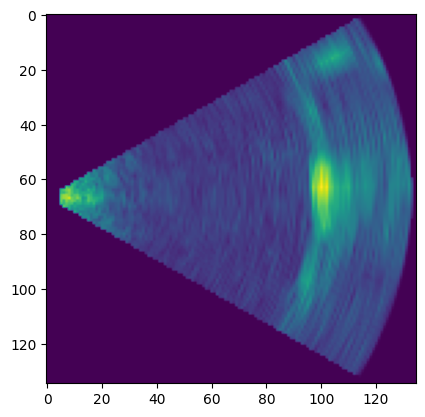

In [5]:
from PIL import Image
import matplotlib.pyplot as plt
from PIL import Image
from utils.type_reader import get_image_array

#Check that frames are being displayed correctly
input_image = get_image_array(all_files_mhd[0])
plt.imshow(input_image[:, :, 69, 3])

In [6]:
X = np.vstack((all_frames_filenames_array, frame_nums)).transpose()
y = labels
print(X.shape)
print(X[0, :])
print(y[0, :])

(17717, 2)
['/data/Riabova/train3/0_22_5_0_0_0_3_1_1686308127391259.mhd' '0.0']
[ 91.57465921  94.48928267 106.19458738]


<font size="4">Setting parameters:</font>

In [7]:
SPLIT_PERCENT = 0.2
IMG_SIZE = 135
EPOCHS = 20
BATCH_TRAIN = 5
BATCH_VALID = 5

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=SPLIT_PERCENT, random_state=42,shuffle=True)

In [9]:
from utils.ImageDataset import ImageDataset
import torch
train_dataset = ImageDataset(X_train,y_train)
valid_dataset = ImageDataset(X_valid,y_valid)
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=BATCH_TRAIN,shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset,batch_size=BATCH_VALID,shuffle=True)

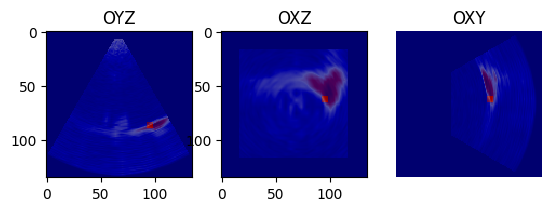

In [10]:
from utils.display_utils import show_sample

show_sample(train_dataset[0])

In [1]:
# define the number of channels in the input, number of classes,
# and number of levels in the U-Net model
NUM_CHANNELS = 135
NUM_CLASSES = 2
NUM_LEVELS = 3
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 0.001
WEIGHT_DECAY = 1e-8,
MOMENTUM = 0.999,
NUM_EPOCHS = 40
BATCH_SIZE = 64
# define the input image dimensions
INPUT_IMAGE_WIDTH = 135
INPUT_IMAGE_HEIGHT = 135
# define threshold to filter weak predictions
THRESHOLD = 0.5

In [2]:
import argparse
import random
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from pathlib import Path
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from unet.UNet import UNet
import wandb

model = UNet(NUM_CHANNELS, NUM_CLASSES)
optimizer = optim.RMSprop(model.parameters(),lr=INIT_LR, weight_decay=WEIGHT_DECAY, momentum=MOMENTUM, foreach=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)  # goal: maximize Dice score
grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
criterion = nn.CrossEntropyLoss() if model.n_classes > 1 else nn.BCEWithLogitsLoss()
global_step = 0

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.3) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


TypeError: '<=' not supported between instances of 'float' and 'tuple'

In [ ]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(config.NUM_EPOCHS)):
	# set the model in training mode
	unet.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0
	# loop over the training set
	for (i, (x, y)) in enumerate(trainLoader):
		# send the input to the device
		(x, y) = (x.to(config.DEVICE), y.to(config.DEVICE))
		# perform a forward pass and calculate the training loss
		pred = unet(x)
		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		unet.eval()
		# loop over the validation set
		for (x, y) in testLoader:
			# send the input to the device
			(x, y) = (x.to(config.DEVICE), y.to(config.DEVICE))
			# make the predictions and calculate the validation loss
			pred = unet(x)
			totalTestLoss += lossFunc(pred, y)
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, config.NUM_EPOCHS))
	print("Train loss: {:.6f}, Test loss: {:.4f}".format(
		avgTrainLoss, avgTestLoss))
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))